In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [2]:
# DSP data
fpath = "../../data/DNN_data/"

sig = np.load(fpath + "data_ssignal" + ".npy")
artifact = np.load(fpath + "data_sine_wave" + ".npy")
sig_with_artifact = sig + artifact

sig_with_artifact.shape

,atf_1,atf_2,atf_3,atf_4,atf_5,atf_6,atf_7,atf_8,atf_9,atf_10,...,atf_991,atf_992,atf_993,atf_994,atf_995,atf_996,atf_997,atf_998,atf_999,atf_1000
Time,,,,,,,,,,,,,,,,,,,,,
0.0000,-1.620639,-0.344656,0.738390,0.015828,-0.313703,1.429779,-1.298719,-1.262644,0.335509,-0.234049,...,0.138118,-0.233716,-0.523072,-0.872986,-1.216870,0.437398,0.344565,0.770516,0.762301,0.501377
0.0005,0.674869,1.980675,2.780476,2.131226,1.928662,3.881064,0.878529,1.120211,2.836969,1.796019,...,2.396320,2.116018,1.638987,1.252414,1.074454,2.655888,2.516668,2.979046,3.069472,2.727449
0.0010,2.612785,3.948056,4.468595,3.938406,3.807488,5.966526,2.676106,3.109478,4.951797,3.511118,...,4.306518,4.074591,3.439530,3.036832,3.004480,4.519540,4.314789,4.847635,5.020824,4.534016
0.0015,3.903561,5.204072,5.587671,5.168735,5.040454,7.326909,3.840158,4.425283,6.290754,4.673809,...,5.567185,5.348558,4.659021,4.129067,4.239176,5.676585,5.494394,6.030884,6.287660,5.688228
0.0020,4.292507,5.640928,5.893576,5.610811,5.435266,7.741859,4.192125,4.863248,6.684277,5.021957,...,5.983984,5.757857,5.037905,4.483477,4.578483,6.037584,5.846699,6.323603,6.704715,5.981250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1.9975,-3.003126,-4.042860,-5.033241,-3.153411,-3.757604,-4.686160,-2.911171,-5.174483,-4.439566,-4.115619,...,-4.318066,-4.939887,-3.037467,-3.692239,-4.704625,-3.656519,-3.580824,-4.737826,-2.048634,-2.887550
1.9980,-3.679509,-4.728691,-5.611209,-3.800321,-4.348560,-5.376384,-3.501736,-5.999171,-5.100859,-4.686947,...,-4.979437,-5.598542,-3.646818,-4.294484,-5.272527,-4.226979,-4.179074,-5.399757,-2.646052,-3.622205
1.9985,-3.446496,-4.499484,-5.349273,-3.601638,-4.120645,-5.083666,-3.187494,-5.828459,-4.777051,-4.426142,...,-4.760802,-5.257491,-3.446330,-4.055384,-4.915863,-3.972343,-3.978880,-5.161811,-2.341457,-3.486393


Text(0.5, 1.0, 'Original Signal')

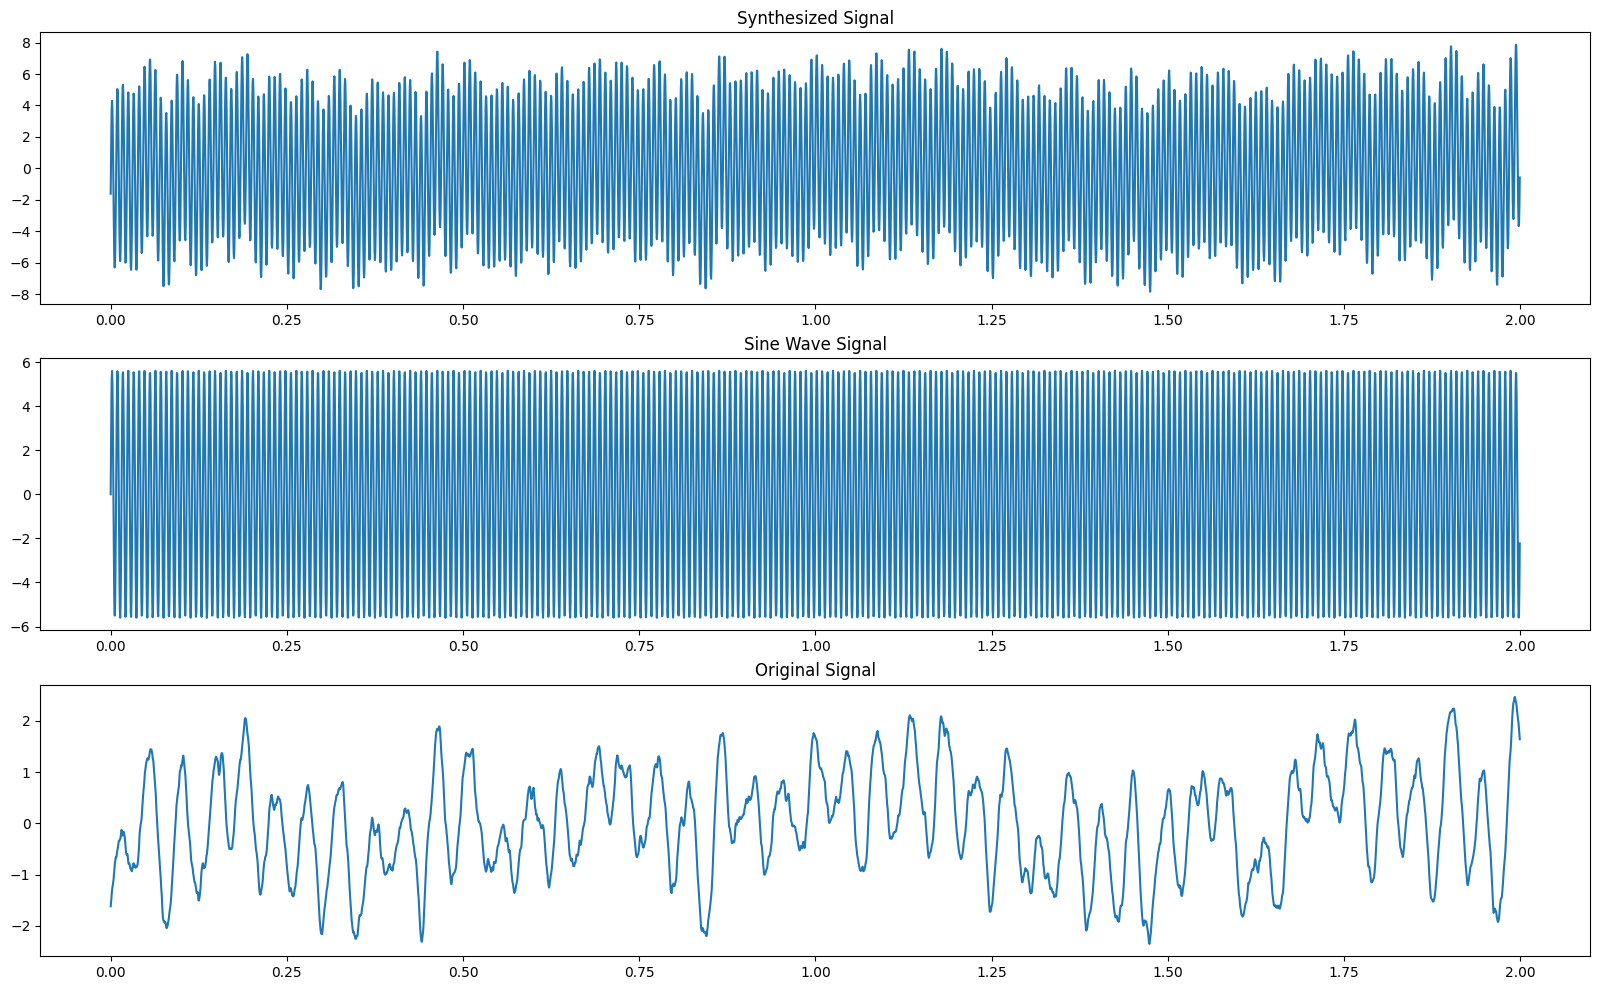

In [3]:
plt.figure(figsize=(20,12))
plt.subplot(3, 1, 1)
plt.plot(data1.iloc[:,0])
plt.title('Synthesized Signal')

plt.subplot(3, 1, 2)
plt.plot(data2.iloc[:,0])
plt.title('Sine Wave Signal')

plt.subplot(3, 1, 3)
plt.plot(data3.iloc[:,0])
plt.title('Original Signal')

In [4]:
# 데이터 통합 (열 단위로 concat)
#df_combined = pd.concat([data1, data2, data3], axis=1)

# sine 없이
df_combined = pd.concat([data1, data3], axis=1).transpose()

df_combined

Time,0.0000,0.0005,0.0010,0.0015,0.0020,0.0025,0.0030,0.0035,0.0040,0.0045,...,1.9950,1.9955,1.9960,1.9965,1.9970,1.9975,1.9980,1.9985,1.9990,1.9995
atf_1,-1.620639,0.674869,2.612785,3.903561,4.292507,3.736683,2.347137,0.385120,-1.813051,-3.874891,...,6.820279,5.080176,2.858647,0.527359,-1.541923,-3.003126,-3.679509,-3.446496,-2.365737,-0.583911
atf_2,-0.344656,1.980675,3.948056,5.204072,5.640928,5.159048,3.867160,1.953067,-0.207864,-2.236002,...,5.915969,4.163614,1.882731,-0.427864,-2.539625,-4.042860,-4.728691,-4.499484,-3.354093,-1.539928
atf_3,0.738390,2.780476,4.468595,5.587671,5.893576,5.325884,3.995559,2.130220,0.011820,-1.957612,...,3.872093,2.281175,0.242867,-1.869356,-3.727473,-5.033241,-5.611209,-5.349273,-4.363960,-2.753930
atf_4,0.015828,2.131226,3.938406,5.168735,5.610811,5.302655,4.227768,2.629075,0.753692,-1.024967,...,5.750409,4.214359,2.229363,0.123911,-1.763611,-3.153411,-3.800321,-3.601638,-2.678478,-1.160304
atf_5,-0.313703,1.928662,3.807488,5.040454,5.435266,4.896448,3.562822,1.710188,-0.446202,-2.452227,...,5.344462,3.673664,1.600210,-0.519723,-2.411906,-3.757604,-4.348560,-4.120645,-3.042687,-1.356623
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
sim_996,0.437398,0.652485,0.842274,0.930334,1.003061,1.078522,1.141508,1.189556,1.240876,1.323292,...,1.095208,1.054989,1.014747,0.927864,0.893569,0.838143,0.807544,0.773909,0.692654,0.609593
sim_997,0.344565,0.459247,0.538374,0.620170,0.676431,0.717730,0.751774,0.819843,0.839359,0.841467,...,1.115032,1.145645,1.141030,1.107589,1.063961,1.035027,0.991194,0.895344,0.816508,0.733165
sim_998,0.770516,0.757465,0.769901,0.767748,0.740802,0.700159,0.688945,0.701894,0.706499,0.720926,...,0.533835,0.510901,0.459072,0.404474,0.326853,0.246322,0.183044,0.101324,0.014966,-0.083230
sim_999,0.762301,0.844257,0.936422,1.015918,1.112785,1.240978,1.328105,1.439750,1.478904,1.503686,...,2.906845,2.927043,2.969031,2.980561,2.948777,2.943664,2.945879,2.930286,2.867566,2.827541


In [5]:
# 정규화
scaler = MinMaxScaler()
df_combined_scaled = scaler.fit_transform(df_combined)

df_combined_scaled.shape

# 추가
# df_combined_scaled = df_combined_scaled.transpose()

df_combined_scaled.shape

(2000, 4000)

In [6]:
# 입력과 출력 정의
num_samples = 4000
num_signals = 1000

# X = df_combined_scaled[:, :2*num_signals].reshape(num_samples, num_signals, 2)  # (4000, 1000, 2)
# y = df_combined_scaled[:, 2*num_signals:].reshape(num_samples, num_signals, 1)  # (4000, 1000, 1)

X = df_combined_scaled[:1000, :].reshape(1000, 4000, 1)
y = df_combined_scaled[1000:, :].reshape(1000, 4000, 1)

X.shape, y.shape

((1000, 4000, 1), (1000, 4000, 1))

In [7]:
# X_train = torch.tensor(X[:,:800,:], dtype=torch.float32).to(device)
# y_train = torch.tensor(y[:,:800,:], dtype=torch.float32).to(device)
# X_val = torch.tensor(X[:,800:1000,:], dtype=torch.float32).to(device)
# y_val = torch.tensor(y[:,800:1000,:], dtype=torch.float32).to(device)

# 훈련 세트와 검증 세트로 분할
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# PyTorch Tensor로 변환
X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
X_val = torch.tensor(X_val, dtype=torch.float32).to(device)
y_val = torch.tensor(y_val, dtype=torch.float32).to(device)

# X_train_tensors = Variable(torch.Tensor(X_train))
# X_test_tensors = Variable(torch.Tensor(X_val))

# y_train_tensors = Variable(torch.Tensor(y_train))
# y_test_tensors = Variable(torch.Tensor(y_val))

X_train.shape, y_train.shape

(torch.Size([800, 4000, 1]), torch.Size([800, 4000, 1]))

In [8]:
# LSTM 모델 정의
class LSTM(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(LSTM, self).__init__()
        self.num_classes = num_classes # 클래스 개수
        self.num_layers = num_layers # LSTM 계층의 개수
        self.input_size = input_size # 입력 크기로 훈련 데이터셋의 칼럼 개수를 의미
        self.hidden_size = hidden_size # hidden layer의 뉴런 개수
        self.seq_length = seq_length # 시퀀스 길이

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True) # LSTM 계층
        self.fc_1 =  nn.Linear(hidden_size, 128) # 완전연결층
        self.fc = nn.Linear(128, num_classes) # 출력층

        self.relu = nn.ReLU()
    
    def forward(self,x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to(device) # 은닉 상태를 0으로 초기화
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to(device) # 셀 상태를 0으로 초기화
        
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) # LSTM 계층에 은닉 상태와 셀 상태 적용
        output = output.reshape(-1, self.hidden_size) # fc layer 적용을 위해 데이터를 1차원 형태로 조정
        out = self.relu(output)
        out = self.fc_1(out) 
        out = self.relu(out) 
        out = self.fc(out)
        return out

In [9]:
# 모델 인스턴스 생성
input_size = 1  # 입력 크기 (sine wave와 synthesized 신호)
hidden_size = 16  # 임의의 hidden layer 크기
num_layers = 2  # 임의의 LSTM layer 개수
num_classes = 1  # 출력 크기 (original 신호)
seq_length = num_samples  # 시퀀스 길이 (4000)

model = LSTM(num_classes, input_size, hidden_size, num_layers, seq_length).to(device)

# 손실 함수와 옵티마이저 정의
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [10]:
# batch_size = 32
# X_batch = X_train[:batch_size].to(device)
# y_batch = y_train[:batch_size].to(device)
# outputs = model(X_batch).to(device)
# loss = criterion(outputs, y_batch.view(-1, num_classes))
# print('X_batch size: ', X_batch.size())
# print('y_batch size: ', y_batch.size())
# print('output size:', outputs.size())
# print('y_batch.view: ', y_batch.view(-1, num_classes).size())

In [11]:
# 모델 훈련
num_epochs = 50
batch_size = 50

for epoch in range(num_epochs):
    for i in range(0, len(X_train), batch_size):
        X_batch = X_train[i:i+batch_size].to(device)
        y_batch = y_train[i:i+batch_size].to(device)
        
        # Forward pass
        outputs = model(X_batch).to(device)
        optimizer.zero_grad()
        
        # Calculate loss
        loss = criterion(outputs, y_batch.view(-1, num_classes))
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
    if epoch%1 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [1/50], Loss: 0.1427
Epoch [2/50], Loss: 0.0579
Epoch [3/50], Loss: 0.0576
Epoch [4/50], Loss: 0.0573
Epoch [5/50], Loss: 0.0564
Epoch [6/50], Loss: 0.0542
Epoch [7/50], Loss: 0.0463
Epoch [8/50], Loss: 0.0131
Epoch [9/50], Loss: 0.0054
Epoch [10/50], Loss: 0.0039
Epoch [11/50], Loss: 0.0035
Epoch [12/50], Loss: 0.0031
Epoch [13/50], Loss: 0.0028
Epoch [14/50], Loss: 0.0026
Epoch [15/50], Loss: 0.0023
Epoch [16/50], Loss: 0.0021
Epoch [17/50], Loss: 0.0020
Epoch [18/50], Loss: 0.0019
Epoch [19/50], Loss: 0.0018
Epoch [20/50], Loss: 0.0017
Epoch [21/50], Loss: 0.0016
Epoch [22/50], Loss: 0.0016
Epoch [23/50], Loss: 0.0015
Epoch [24/50], Loss: 0.0015
Epoch [25/50], Loss: 0.0014
Epoch [26/50], Loss: 0.0014
Epoch [27/50], Loss: 0.0013
Epoch [28/50], Loss: 0.0013
Epoch [29/50], Loss: 0.0012
Epoch [30/50], Loss: 0.0012
Epoch [31/50], Loss: 0.0011
Epoch [32/50], Loss: 0.0011
Epoch [33/50], Loss: 0.0011
Epoch [34/50], Loss: 0.0012
Epoch [35/50], Loss: 0.0010
Epoch [36/50], Loss: 0.0010
E

In [12]:
# 모델 평가
model.eval()
with torch.no_grad():
    val_outputs = model(X_val)
    val_loss = criterion(val_outputs, y_val.view(-1, num_classes))
    print(f'Validation Loss: {val_loss.item():.4f}')


Validation Loss: 0.0008


torch.Size([800, 1000, 1])


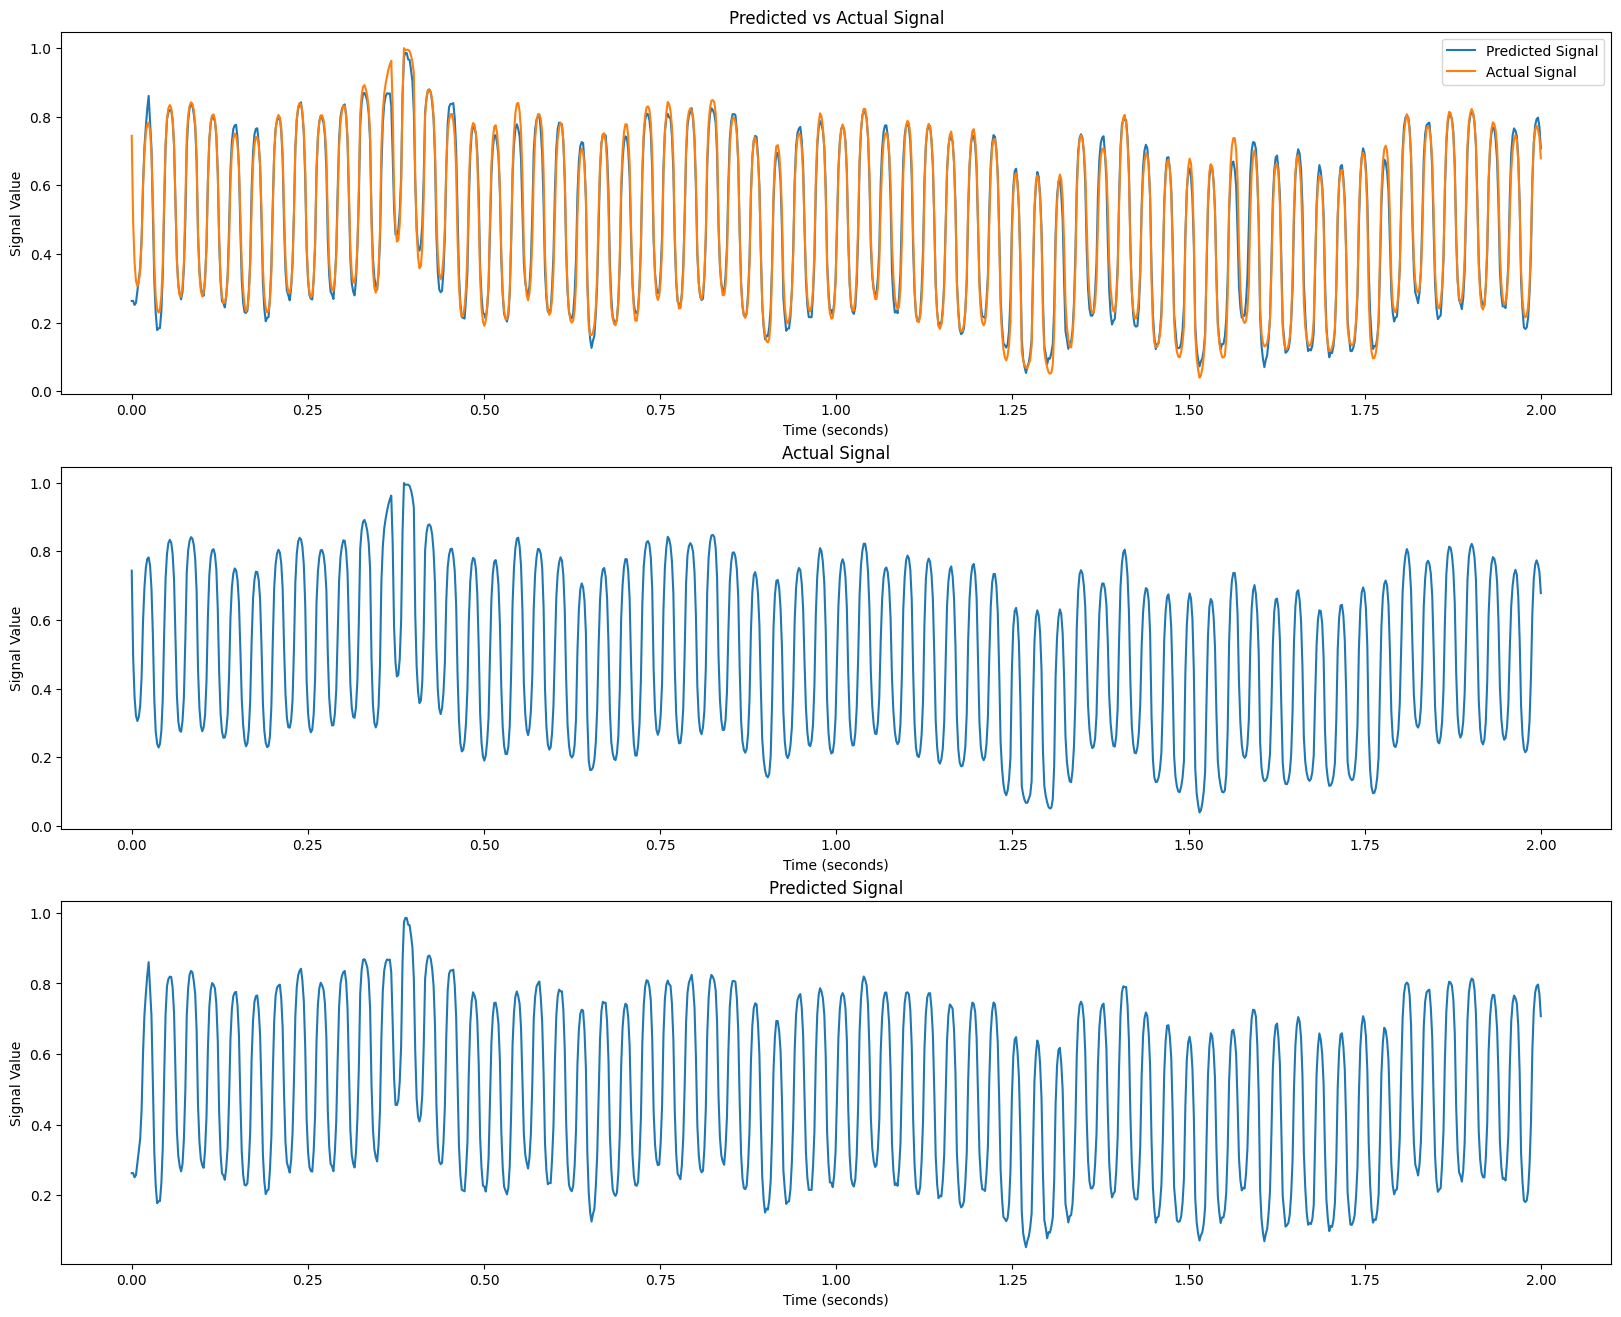

In [13]:
# 검증 데이터 중 첫 번째 샘플에 대한 예측과 실제 값을 플롯
val_outputs = val_outputs.view(-1, num_signals, num_classes)  # reshape to (batch_size, seq_length, num_classes)
y_val = y_val.view(-1, num_signals, num_classes)
print(y_val.shape)

# 첫 번째 샘플의 첫 번째 신호만 선택하여 플롯 (여러 신호 중 하나만 플롯하는 예시)
sample_idx = 0
signal_idx = 0

predicted_signal = val_outputs[sample_idx, :, signal_idx].cpu().numpy()
actual_signal = y_val[sample_idx, :, signal_idx].cpu().numpy()

# 타임 스텝을 시간 단위로 변환
time_steps = np.linspace(0, 2, num=num_signals)  # 2초 동안 1000개의 샘플

plt.figure(figsize=(20, 16))
plt.subplot(3, 1, 1)
plt.plot(time_steps, predicted_signal, label='Predicted Signal')
plt.plot(time_steps, actual_signal, label='Actual Signal')
plt.xlabel('Time (seconds)')
plt.ylabel('Signal Value')
plt.title('Predicted vs Actual Signal')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(time_steps, actual_signal)
plt.xlabel('Time (seconds)')
plt.ylabel('Signal Value')
plt.title('Actual Signal')

plt.subplot(3, 1, 3)
plt.plot(time_steps, predicted_signal)
plt.xlabel('Time (seconds)')
plt.ylabel('Signal Value')
plt.title('Predicted Signal')

plt.show()


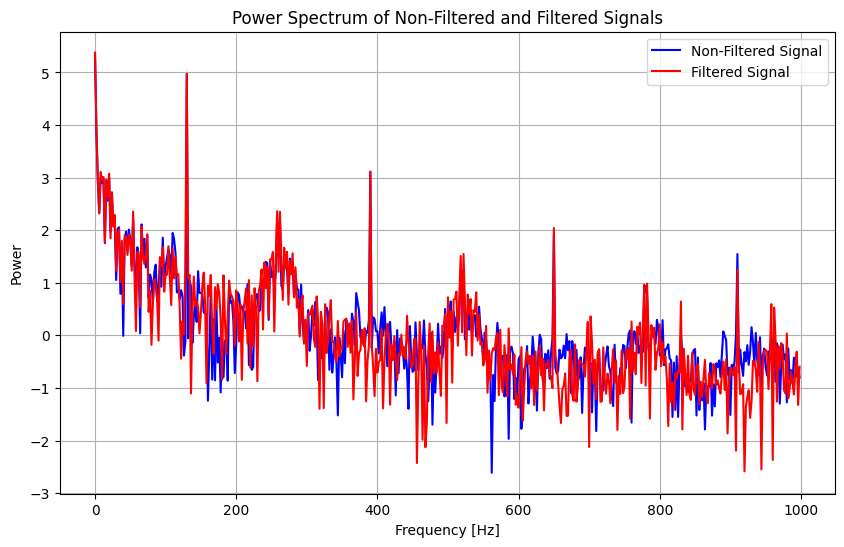

In [14]:
n = len(predicted_signal)

fs = 2000
freqs = np.fft.fftfreq(n, d=1/fs)[:n//2]

fft_predicted = np.fft.fft(predicted_signal)
fft_predicted = np.abs(fft_predicted[:n//2])
fft_predicted[1:] = 2 * fft_predicted[1:]
power1 = fft_predicted**2

fft_actual = np.fft.fft(actual_signal)
fft_actual = np.abs(fft_actual[:n//2])
fft_actual[1:] = 2 * fft_actual[1:]
power2 = fft_actual**2

# 결과 플로팅
plt.figure(figsize=(10, 6))
plt.plot(freqs, np.log10(power1), label='Non-Filtered Signal', color='blue')
plt.plot(freqs, np.log10(power2), label='Filtered Signal', color='red')
plt.title('Power Spectrum of Non-Filtered and Filtered Signals')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Power')
plt.legend()
plt.grid(True)
plt.show()